# Using Torch FedAvg on MNIST dataset

This example illustrates the basic usage of SubstraFL and proposes Federated Learning using the Federated Averaging strategy
on the [MNIST Dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) using PyTorch.
In this example, we work on 28x28 pixel sized grayscale images. This is a classification problem
aiming to recognize the number written on each image.

SubstraFL can be used with any machine learning framework (PyTorch, Tensorflow, Scikit-Learn, etc).

However a specific interface has been developed for PyTorch which makes writing PyTorch code simpler than with other frameworks. This example here uses the specific PyTorch interface.

This example does not use a deployed platform of Substra and runs in local mode.

To run this example, you need to download and unzip the assets needed to run it in the same directory as used this example:

- [assets required to run this example](../../../tmp/torch_fedavg_assets.zip)

Please ensure to have all the libraries installed. A *requirements.txt* file is included in the zip file, where you can run the command `pip install -r requirements.txt` to install them.

**Substra** and **SubstraFL** should already be installed. If not, follow the instructions described [here](https://docs.substra.org/en/stable/substrafl_doc/substrafl_overview.html#installation).


## Setup

This example runs with three organizations. Two organizations provide datasets, while a third
one provides the algorithm.

In the following code cell, we define the different organizations needed for our FL experiment.



In [1]:
from substra import Client

N_CLIENTS = 3

client_0 = Client(client_name="org-1")
client_1 = Client(client_name="org-2")
client_2 = Client(client_name="org-3")

/home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/conda/0.36.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Every computation will run in ``subprocess`` mode, where everything runs locally in Python
subprocesses.
Other backend_types are:

- ``docker`` mode where computations run locally in docker containers
- ``remote`` mode where computations run remotely (you need to have a deployed platform for that)

To run in remote mode, use the following syntax:

```py
client_remote = Client(backend_type="remote", url="MY_BACKEND_URL", username="my-username", password="my-password")
```



In [2]:
# Create a dictionary to easily access each client from its human-friendly id
clients = {
    client_0.organization_info().organization_id: client_0,
    client_1.organization_info().organization_id: client_1,
    client_2.organization_info().organization_id: client_2,
}

# Store organization IDs
ORGS_ID = list(clients)
ALGO_ORG_ID = ORGS_ID[0]  # Algo provider is defined as the first organization.
DATA_PROVIDER_ORGS_ID = ORGS_ID[1:]  # Data providers orgs are the two last organizations.

## Data and metrics

### Data preparation

This section downloads (if needed) the **MNIST dataset** using the [torchvision library](https://pytorch.org/vision/stable/index.html).
It extracts the images from the raw files and locally creates a folder for each
organization.

Each organization will have access to half the training data and half the test data (which
corresponds to **30,000**
images for training and **5,000** for testing each).



In [3]:
import pathlib
from torch_fedavg_assets.dataset.mnist_dataset import setup_mnist


# Create the temporary directory for generated data
(pathlib.Path.cwd() / "tmp").mkdir(exist_ok=True)
data_path = pathlib.Path.cwd() / "tmp" / "data_mnist"

setup_mnist(data_path, len(DATA_PROVIDER_ORGS_ID))

  0%|          | 0/9912422 [00:00<?, ?it/s]

 87%|████████▋ | 8650752/9912422 [00:00<00:00, 86321347.77it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 93890421.07it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

100%|██████████| 28881/28881 [00:00<00:00, 121500194.41it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

100%|██████████| 1648877/1648877 [00:00<00:00, 36680711.54it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

100%|██████████| 4542/4542 [00:00<00:00, 5681636.97it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/0.36.0/docs/source/examples/substrafl/get_started/tmp/data_mnist/MNIST/raw



### Dataset registration

A [Dataset](https://docs.substra.org/en/stable/documentation/concepts.html#dataset) is composed of an **opener**, which is a Python script that can load
the data from the files in memory and a description markdown file.
The [Dataset](https://docs.substra.org/en/stable/documentation/concepts.html#dataset) object itself does not contain the data. The proper asset that contains the
data is the **datasample asset**.

A **datasample** contains a local path to the data. A datasample can be linked to a dataset in order to add data to a
dataset.

Data privacy is a key concept for Federated Learning experiments. That is why we set
[Permissions](https://docs.substra.org/en/stable/documentation/concepts.html#permissions) for an [Asset](https://docs.substra.org/en/stable/documentation/concepts.html#permissions) to determine how each organization
can access a specific asset.

Note that metadata such as the assets' creation date and the asset owner are visible to all the organizations of a
network.



In [4]:
from substra.sdk.schemas import DatasetSpec
from substra.sdk.schemas import Permissions
from substra.sdk.schemas import DataSampleSpec

assets_directory = pathlib.Path.cwd() / "torch_fedavg_assets"
dataset_keys = {}
train_datasample_keys = {}
test_datasample_keys = {}

for i, org_id in enumerate(DATA_PROVIDER_ORGS_ID):
    client = clients[org_id]

    permissions_dataset = Permissions(public=False, authorized_ids=[ALGO_ORG_ID])

    # DatasetSpec is the specification of a dataset. It makes sure every field
    # is well-defined, and that our dataset is ready to be registered.
    # The real dataset object is created in the add_dataset method.

    dataset = DatasetSpec(
        name="MNIST",
        type="npy",
        data_opener=assets_directory / "dataset" / "mnist_opener.py",
        description=assets_directory / "dataset" / "description.md",
        permissions=permissions_dataset,
        logs_permission=permissions_dataset,
    )
    dataset_keys[org_id] = client.add_dataset(dataset)
    assert dataset_keys[org_id], "Missing dataset key"

    # Add the training data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "train",
    )
    train_datasample_keys[org_id] = client.add_data_sample(data_sample)

    # Add the testing data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "test",
    )
    test_datasample_keys[org_id] = client.add_data_sample(data_sample)

### Metrics definition

A metric is a function used to evaluate the performance of your model.

To add a metric, you need to define a function that computes and returns a performance
from the data (as returned by the opener) and the predictions of the model.

When using a Torch SubstraFL algorithm, the predictions are returned by the `predict` function.


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np


def accuracy(data_from_opener, predictions):
    y_true = data_from_opener["labels"]

    return accuracy_score(y_true, np.argmax(predictions, axis=1))


def roc_auc(data_from_opener, predictions):
    y_true = data_from_opener["labels"]

    n_class = np.max(y_true) + 1
    y_true_one_hot = np.eye(n_class)[y_true]

    return roc_auc_score(y_true_one_hot, predictions)

## Machine learning components definition

This section uses the PyTorch based SubstraFL API to simplify the definition of machine learning components.
However, SubstraFL is compatible with any machine learning framework.


In this section, you will:

- Register a model and its dependencies
- Specify the federated learning strategy
- Specify the training and aggregation nodes
- Specify the test nodes
- Actually run the computations



### Model definition

We choose to use a classic torch CNN as the model to train. The model architecture is defined by the user
independently of SubstraFL.



In [6]:
import torch
from torch import nn
import torch.nn.functional as F

seed = 42
torch.manual_seed(seed)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3 * 3 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x, eval=False):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=not eval)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=not eval)
        x = x.view(-1, 3 * 3 * 64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=not eval)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

### Specifying on how much data to train

To specify on how much data to train at each round, we use the `index_generator` object.
We specify the batch size and the number of batches (named `num_updates`) to consider for each round.
See [Index Generator](https://docs.substra.org/en/stable/substrafl_doc/substrafl_overview.html#index-generator) for more details.



In [7]:
from substrafl.index_generator import NpIndexGenerator

# Number of model updates between each FL strategy aggregation.
NUM_UPDATES = 100

# Number of samples per update.
BATCH_SIZE = 32

index_generator = NpIndexGenerator(
    batch_size=BATCH_SIZE,
    num_updates=NUM_UPDATES,
)

### Torch Dataset definition

This torch Dataset is used to preprocess the data using the `__getitem__` function.

This torch Dataset needs to have a specific `__init__` signature, that must contain (self, data_from_opener, is_inference).

The `__getitem__` function is expected to return (inputs, outputs) if `is_inference` is `False`, else only the inputs.
This behavior can be changed by re-writing the `_local_train` or `predict` methods.



In [8]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, data_from_opener, is_inference: bool):
        self.x = data_from_opener["images"]
        self.y = data_from_opener["labels"]
        self.is_inference = is_inference

    def __getitem__(self, idx):
        if self.is_inference:
            x = torch.FloatTensor(self.x[idx][None, ...]) / 255
            return x

        else:
            x = torch.FloatTensor(self.x[idx][None, ...]) / 255

            y = torch.tensor(self.y[idx]).type(torch.int64)
            y = F.one_hot(y, 10)
            y = y.type(torch.float32)

            return x, y

    def __len__(self):
        return len(self.x)

### SubstraFL algo definition

A SubstraFL Algo gathers all the defined elements that run locally in each organization.
This is the only SubstraFL object that is framework specific (here PyTorch specific).

The `TorchDataset` is passed **as a class** to the
[Torch Algorithms](https://docs.substra.org/en/stable/substrafl_doc/api/algorithms.html#torch-algorithms).
Indeed, this `TorchDataset` will be instantiated directly on the data provider organization.



In [9]:
from substrafl.algorithms.pytorch import TorchFedAvgAlgo


class TorchCNN(TorchFedAvgAlgo):
    def __init__(self):
        super().__init__(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            index_generator=index_generator,
            dataset=TorchDataset,
            seed=seed,
            use_gpu=False,
        )

### Federated Learning strategies

A FL strategy specifies how to train a model on distributed data.
The most well known strategy is the Federated Averaging strategy: train locally a model on every organization,
then aggregate the weight updates from every organization, and then apply locally at each organization the averaged
updates.



In [10]:
from substrafl.strategies import FedAvg

strategy = FedAvg(algo=TorchCNN(), metric_functions={"Accuracy": accuracy, "ROC AUC": roc_auc})

### Where to train where to aggregate

We specify on which data we want to train our model, using the [TrainDataNode](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#traindatanode) object.
Here we train on the two datasets that we have registered earlier.

The [AggregationNode](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#aggregationnode) specifies the organization on which the aggregation operation
will be computed.



In [11]:
from substrafl.nodes import TrainDataNode
from substrafl.nodes import AggregationNode


aggregation_node = AggregationNode(ALGO_ORG_ID)

# Create the Train Data Nodes (or training tasks) and save them in a list
train_data_nodes = [
    TrainDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[train_datasample_keys[org_id]],
    )
    for org_id in DATA_PROVIDER_ORGS_ID
]

### Where and when to test

With the same logic as the train nodes, we create [TestDataNode](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#testdatanode) to specify on which
data we want to test our model.

The [Evaluation Strategy](https://docs.substra.org/en/stable/substrafl_doc/api/evaluation_strategy.html) defines where and at which frequency we
evaluate the model, using the given metric(s) that you registered in a previous section.



In [12]:
from substrafl.nodes import TestDataNode
from substrafl.evaluation_strategy import EvaluationStrategy

# Create the Test Data Nodes (or testing tasks) and save them in a list
test_data_nodes = [
    TestDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[test_datasample_keys[org_id]],
    )
    for org_id in DATA_PROVIDER_ORGS_ID
]


# Test at the end of every round
my_eval_strategy = EvaluationStrategy(test_data_nodes=test_data_nodes, eval_frequency=1)

## Running the experiment

As a last step before launching our experiment, we need to specify the third parties dependencies required to run it.
The [Dependency](https://docs.substra.org/en/stable/substrafl_doc/api/dependency.html) object is instantiated in order to install the right libraries in
the Python environment of each organization.

The CPU torch version is installed here to have a `Dependency` object as light as possible as we don't use GPUs (`use_gpu` set to `False`). Remove the `--extra-index-url` to install the cuda torch version.

In [13]:
from substrafl.dependency import Dependency

dependencies = Dependency(pypi_dependencies=["numpy==1.24.3", "scikit-learn==1.3.1", "torch==2.0.1", "--extra-index-url https://download.pytorch.org/whl/cpu"])

We now have all the necessary objects to launch our experiment. Please see a summary below of all the objects we created so far:

- A [Client](https://docs.substra.org/en/stable/documentation/references/sdk.html#client) to add or retrieve the assets of our experiment, using their keys to
  identify them.
- An [Torch Algorithms](https://docs.substra.org/en/stable/substrafl_doc/api/algorithms.html#torch-algorithms) to define the training parameters *(optimizer, train
  function, predict function, etc...)*.
- A [Strategies](https://docs.substra.org/en/stable/substrafl_doc/api/strategies.html#strategies), to specify how to train the model on
  distributed data.
- [Train data nodes](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#traindatanode) to indicate on which data to train.
- An [Evaluation Strategy](https://docs.substra.org/en/stable/substrafl_doc/api/evaluation_strategy.html#evaluation-strategy), to define where and at which frequency we
  evaluate the model.
- An [Aggregation Node](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#aggregationnode), to specify the organization on which the aggregation operation
  will be computed.
- The **number of rounds**, a round being defined by a local training step followed by an aggregation operation.
- An **experiment folder** to save a summary of the operation made.
- The [Dependency](https://docs.substra.org/en/stable/substrafl_doc/api/dependency.html) to define the libraries on which the experiment needs to run.



In [14]:
from substrafl.experiment import execute_experiment
import logging
import substrafl

substrafl.set_logging_level(loglevel=logging.ERROR)
# A round is defined by a local training step followed by an aggregation operation
NUM_ROUNDS = 3

compute_plan = execute_experiment(
    client=clients[ALGO_ORG_ID],
    strategy=strategy,
    train_data_nodes=train_data_nodes,
    evaluation_strategy=my_eval_strategy,
    aggregation_node=aggregation_node,
    num_rounds=NUM_ROUNDS,
    experiment_folder=str(pathlib.Path.cwd() / "tmp" / "experiment_summaries"),
    dependencies=dependencies,
    clean_models=False,
    name="MNIST documentation example",
)

Rounds progress:   0%|          | 0/3 [00:00<?, ?it/s]

Rounds progress: 100%|██████████| 3/3 [00:00<00:00, 1210.01it/s]

Compute plan progress:   0%|          | 0/21 [00:00<?, ?it/s]

Compute plan progress:   5%|▍         | 1/21 [00:02<00:46,  2.34s/it]

Compute plan progress:  10%|▉         | 2/21 [00:04<00:41,  2.18s/it]

Compute plan progress:  14%|█▍        | 3/21 [00:10<01:10,  3.90s/it]

Compute plan progress:  19%|█▉        | 4/21 [00:15<01:15,  4.43s/it]

Compute plan progress:  24%|██▍       | 5/21 [00:21<01:17,  4.84s/it]

Compute plan progress:  29%|██▊       | 6/21 [00:26<01:14,  4.95s/it]

Compute plan progress:  33%|███▎      | 7/21 [00:28<00:58,  4.16s/it]

Compute plan progress:  38%|███▊      | 8/21 [00:34<01:00,  4.65s/it]

Compute plan progress:  43%|████▎     | 9/21 [00:40<00:59,  4.98s/it]

Compute plan progress:  48%|████▊     | 10/21 [00:45<00:55,  5.04s/it]

Compute plan progress:  52%|█████▏    | 11/21 [00:48<00:42,  4.28s/it]

Compute plan progress:  57%|█████▋    | 12/21 [00:52<00:40,  4.49s/it]

Compute plan progress:  62%|██████▏   | 13/21 [00:58<00:38,  4.86s/it]

Compute plan progress:  67%|██████▋   | 14/21 [01:04<00:35,  5.11s/it]

Compute plan progress:  71%|███████▏  | 15/21 [01:09<00:30,  5.13s/it]

Compute plan progress:  76%|███████▌  | 16/21 [01:12<00:21,  4.35s/it]

Compute plan progress:  81%|████████  | 17/21 [01:16<00:17,  4.45s/it]

Compute plan progress:  86%|████████▌ | 18/21 [01:22<00:14,  4.78s/it]

Compute plan progress:  90%|█████████ | 19/21 [01:27<00:10,  5.03s/it]

Compute plan progress:  95%|█████████▌| 20/21 [01:33<00:05,  5.06s/it]

Compute plan progress: 100%|██████████| 21/21 [01:37<00:00,  4.91s/it]

Compute plan progress: 100%|██████████| 21/21 [01:37<00:00,  4.65s/it]

The compute plan created is composed of 21 tasks:

* For each local training step, we create 2 tasks per organisation: training + evaluation -> 2 tasks.
* We are training on 2 data organizations; for each round, we have 2 * 2 local tasks + 1 aggregation task -> 5 tasks.
* We are training for 3 rounds: 3 * 5 -> 15 tasks.
* Before the first local training step, there is an initialization step on each data organization: 15 + 2 -> 17 tasks.
* After the last aggregation step, there are two more tasks: applying the last updates from the aggregator + evaluation, on both organizations: 17 + 2 * 2 -> 21 tasks



## Explore the results

In [15]:
# The results will be available once the compute plan is completed
client_0.wait_compute_plan(compute_plan.key)

{
    "key": "526fb932-2e37-47a3-823e-997c95eafad0",
    "tag": "",
    "name": "MNIST documentation example",
    "owner": "MyOrg1MSP",
    "metadata": {
        "substrafl_version": "0.44.0",
        "substra_version": "0.51.0",
        "substratools_version": "0.21.2",
        "python_version": "3.10.13"
    },
    "task_count": 21,
    "waiting_builder_slot_count": 0,
    "building_count": 0,
    "waiting_parent_tasks_count": 0,
    "waiting_executor_slot_count": 0,
    "executing_count": 0,
    "canceled_count": 0,
    "failed_count": 0,
    "done_count": 21,
    "failed_task_key": null,
    "status": "PLAN_STATUS_DONE",
    "creation_date": "2024-03-12T16:38:56.535977",
    "start_date": "2024-03-12T16:38:56.535980",
    "end_date": "2024-03-12T16:40:34.166547",
    "estimated_end_date": "2024-03-12T16:40:34.166547",
    "duration": 97,
    "creator": null
}

### List results

In [16]:
import pandas as pd

performances_df = pd.DataFrame(client.get_performances(compute_plan.key).model_dump())
print("\nPerformance Table: \n")
print(performances_df[["worker", "round_idx", "identifier", "performance"]])


Performance Table: 

       worker  round_idx identifier  performance
0   MyOrg2MSP          0   Accuracy     0.103200
1   MyOrg2MSP          0    ROC AUC     0.488957
2   MyOrg3MSP          0   Accuracy     0.113000
3   MyOrg3MSP          0    ROC AUC     0.482147
4   MyOrg2MSP          1   Accuracy     0.742600
5   MyOrg2MSP          1    ROC AUC     0.966865
6   MyOrg3MSP          1   Accuracy     0.827200
7   MyOrg3MSP          1    ROC AUC     0.983022
8   MyOrg2MSP          2   Accuracy     0.889600
9   MyOrg2MSP          2    ROC AUC     0.991484
10  MyOrg3MSP          2   Accuracy     0.941000
11  MyOrg3MSP          2    ROC AUC     0.996967
12  MyOrg2MSP          3   Accuracy     0.918400
13  MyOrg2MSP          3    ROC AUC     0.995377
14  MyOrg3MSP          3   Accuracy     0.951200
15  MyOrg3MSP          3    ROC AUC     0.998003


### Plot results

Matplotlib is building the font cache; this may take a moment.


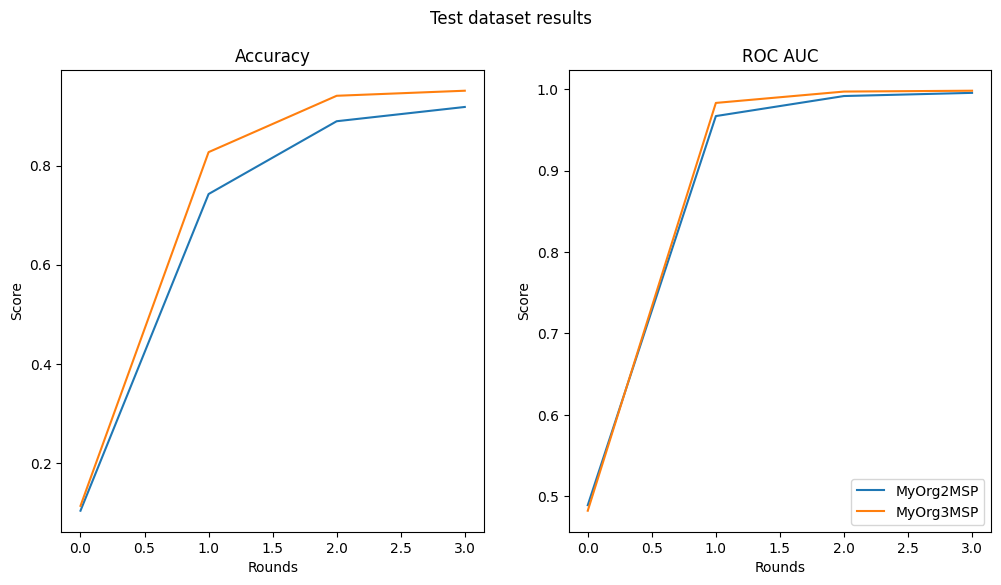

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Test dataset results")

axs[0].set_title("Accuracy")
axs[1].set_title("ROC AUC")

for ax in axs.flat:
    ax.set(xlabel="Rounds", ylabel="Score")


for org_id in DATA_PROVIDER_ORGS_ID:
    org_df = performances_df[performances_df["worker"] == org_id]
    acc_df = org_df[org_df["identifier"] == "Accuracy"]
    axs[0].plot(acc_df["round_idx"], acc_df["performance"], label=org_id)

    auc_df = org_df[org_df["identifier"] == "ROC AUC"]
    axs[1].plot(auc_df["round_idx"], auc_df["performance"], label=org_id)

plt.legend(loc="lower right")
plt.show()

### Download a model

After the experiment, you might be interested in downloading your trained model.
To do so, you will need the source code in order to reload your code architecture in memory.
You have the option to choose the client and the round you are interested in downloading.

If `round_idx` is set to `None`, the last round will be selected by default.



In [18]:
from substrafl.model_loading import download_algo_state

client_to_download_from = DATA_PROVIDER_ORGS_ID[0]
round_idx = None

algo = download_algo_state(
    client=clients[client_to_download_from],
    compute_plan_key=compute_plan.key,
    round_idx=round_idx,
)

model = algo.model

print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
